- http://keunwoochoi.blogspot.com/2016/03/2.html
- http://www.rex-ai.info/docs/AI_Example_CNN_speech_recognize
- https://www.youtube.com/watch?v=oltGIc4uo5c
- https://youdaeng-com.tistory.com/5
- https://quokkas.tistory.com/37 : early stopping
- https://continuous-development.tistory.com/166 : stratified kfold
- https://deep-learning-study.tistory.com/476 fiter 시각화
- https://wyatt37.tistory.com/10 : random over sampling

In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn # 인공 신경망 모델들 모아놓은 모듈
import torch.nn.functional as F #그중 자주 쓰이는것들을 F로
from torchvision import transforms, datasets
import cv2
from torchvision import transforms, datasets
import pandas as pd
import os
from glob import glob
import torchvision.models as models
import sys

p = os.path.abspath('../..') # 상위 폴더를 사용하기 위해서.
sys.path.insert(1, p)
from pytorchtools.pytorchtools import EarlyStopping # 상위 폴더에 추가된 모듈.


if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')
#DEVICE = torch.device('cpu')
print('Using Pytorch version : ',torch.__version__,' Device : ',DEVICE)

Using Pytorch version :  1.10.0  Device :  cuda


# SVD 문장 데이터에서 Feature 추출
- mfcc

In [2]:
import numpy as np
import librosa, librosa.display 
import matplotlib.pyplot as plt
#window sizde : FFT를 할때 참조할 그래프 길이 ( 프레임 하나당 sample 수 )
#자연어 처리에서는 25ms 사용. https://ahnjg.tistory.com/93
#초당 50000hz 중 1250개씩 윈도우 사이즈로 사용.
sr=50000
win_length =  np.int64(50000/40) # 1250
n_fft= win_length # WINDOWS SIZE중 사용할 길이. WINDOW SIZE가 넘어가면 나머지 것들은 zero padding
hop_length= np.int64( np.ceil(win_length/4) ) #  얼마만큼 시간 주기(sample)를 이동하면서 분석을 할 것인지. 일반적으로 window size의 1/4
#또는 10ms만큼으로 한다고 한다.
#hop_length가 mfcc의 frame수를 결정한다.

In [3]:
import numpy as np
import librosa, librosa.display 
import matplotlib.pyplot as plt
#window sizde : FFT를 할때 참조할 그래프 길이 ( 프레임 하나당 sample 수 )
#자연어 처리에서는 25ms 사용. https://ahnjg.tistory.com/93
#초당 50000hz 중 1250개씩 윈도우 사이즈로 사용.
sr=50000
win_length =  np.int64(50000/40) # 1250
n_fft= win_length # WINDOWS SIZE중 사용할 길이. WINDOW SIZE가 넘어가면 나머지 것들은 zero padding
hop_length= np.int64( np.ceil(win_length/4) ) #  얼마만큼 시간 주기(sample)를 이동하면서 분석을 할 것인지. 일반적으로 window size의 1/4
#또는 10ms만큼으로 한다고 한다.
#hop_length가 mfcc의 frame수를 결정한다.

pathology_sig=[]
healthy_sig=[]

pathology=[]
healthy=[]


#PATHOLOGY DATA
for audio_path in os.listdir('../../../voice_data/pathology_new/phrase/export'):
    sig, sr = librosa.load('../../../voice_data/pathology_new/phrase/export/'+audio_path, sr=50000)# 논문에서 f_s = 50 000HZ
    pathology_sig.append(sig)
    mel_feature = librosa.feature.melspectrogram(sig,sr=sr,hop_length=hop_length,n_fft=n_fft)
    mel_feature = librosa.core.power_to_db(mel_feature,ref=np.max)
    pathology.append(mel_feature)
    

#Healthy data
for audio_path in os.listdir('../../../voice_data/healthy_new/phrase/export'):
    sig, sr = librosa.load('../../../voice_data/healthy_new/phrase/export/'+audio_path, sr=50000)# 논문에서 f_s = 50 000HZ
    healthy_sig.append(sig)
    mel_feature = librosa.feature.melspectrogram(sig,sr=sr,hop_length=hop_length,n_fft=n_fft)
    mel_feature = librosa.core.power_to_db(mel_feature,ref=np.max)
    healthy.append(mel_feature)
    
print("pathology data 수 : ",len(pathology))
print("healthy data 수 : ",len(healthy))


path_max=max([ len(samples) for samples in pathology_sig])
healthy_max=max([ len(samples) for samples in healthy_sig])
print("가장 긴 path sample :" ,path_max)
print("가장 긴 healthy sample :" ,healthy_max)

pathology data 수 :  1194
healthy data 수 :  634
가장 긴 path sample : 318596
가장 긴 healthy sample : 207017


In [4]:
print(path_max/sr,"초")
print(healthy_max/sr,"초")

6.37192 초
4.14034 초


# 결과 확인
- 1 row당 1 frame으로

In [5]:
len(healthy[0][2]) #1번 : 파일. 2번:mfcc
#headers = "mfcc1 mfcc2 mfcc3 mfcc4 mfcc5 mfcc6 mfcc7 mfcc8 mfcc9 mfcc10 mfcc11 mfcc12 mfcc13".split()
#pd.DataFrame(healthy[0].T,columns=headers)

print(healthy[0])




[[-40.589996 -39.998337 -38.81555  ... -38.37249  -39.136566 -37.830963]
 [-45.260597 -43.43311  -43.50158  ... -42.478107 -43.67787  -38.517254]
 [-56.9734   -49.211952 -54.667103 ... -49.667316 -53.020805 -38.752518]
 ...
 [-80.       -80.       -80.       ... -80.       -80.       -80.      ]
 [-80.       -80.       -80.       ... -80.       -80.       -80.      ]
 [-80.       -80.       -80.       ... -80.       -80.       -80.      ]]


In [6]:
print(healthy[0].shape) #1번 주파수 축, 2번 시간축.
print(healthy[1].shape)

(128, 326)
(128, 338)


In [7]:
del pathology
del healthy
del pathology_sig
del healthy_sig

# 데이터 나누기 - Stratified KFold

- pathology : 1194 / healthy : 634 / 총 1828
- k = 5

## 1. test/ train 나누기


In [3]:
#1. train, test 나누기

import os
from glob import glob
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
from sklearn.model_selection import train_test_split # train , test 분리에 사용.


pathology = glob('../../../voice_data/pathology_new/phrase/export/*.wav')
healthy = glob('../../../voice_data/healthy_new/phrase/export/*.wav')
print("Pathology : ",len(pathology))
print("Healthy: ",len(healthy))

X = pathology+healthy # path 데이터 합
print("총 데이터수 : ",len(X))
Y = [] # 라벨
for idx,x in enumerate(X):
    if idx<1194:
        Y.append("pathology")
    else:
        Y.append("healthy")

X, X_test, Y, Y_test = train_test_split(X, Y, test_size=0.2, shuffle=True, stratify=Y, random_state=456)
#stratify를 넣어서, test에도 라벨별 잘 분류되게 한다.

print("---")
print("훈련 셋 : ",len(Y),Counter(Y))
print("테스트 셋 : ",len(Y_test),Counter(Y_test))
print("---")

Pathology :  1194
Healthy:  634
총 데이터수 :  1828
---
훈련 셋 :  1462 Counter({'pathology': 955, 'healthy': 507})
테스트 셋 :  366 Counter({'pathology': 239, 'healthy': 127})
---


## 2. random over sampling

In [4]:
#2. random over sampling

X = np.array(X).reshape(-1,1)#각 데이터를 다 행으로 넣음. (1194,1)
#Y = np.array(Y)
ros = RandomOverSampler(random_state = 123)
X_res,Y_res = ros.fit_resample(X,Y)

print('before dataset shape {}'.format(Counter(Y)) )
print('Resampled dataset shape {}'.format(Counter(Y_res)) )


before dataset shape Counter({'pathology': 955, 'healthy': 507})
Resampled dataset shape Counter({'pathology': 955, 'healthy': 955})


In [5]:
X_res

array([['../../../voice_data/pathology_new/phrase/export\\2231-phrase.wav'],
       ['../../../voice_data/healthy_new/phrase/export\\1124-phrase.wav'],
       ['../../../voice_data/pathology_new/phrase/export\\2340-phrase.wav'],
       ...,
       ['../../../voice_data/healthy_new/phrase/export\\2264-phrase.wav'],
       ['../../../voice_data/healthy_new/phrase/export\\1871-phrase.wav'],
       ['../../../voice_data/healthy_new/phrase/export\\1876-phrase.wav']],
      dtype='<U63')

In [6]:
#원래대로 돌리기
X=X_res.reshape(1, -1)
print( '총 데이터수 : ',X[0].size )
print(  '복사된 수 : ',X[0].size - np.unique(X[0]).size )

X=X[0].tolist()
Y=Y_res

총 데이터수 :  1910
복사된 수 :  448


In [12]:
X

['../../../voice_data/pathology_new/phrase/export\\2231-phrase.wav',
 '../../../voice_data/healthy_new/phrase/export\\1124-phrase.wav',
 '../../../voice_data/pathology_new/phrase/export\\2340-phrase.wav',
 '../../../voice_data/pathology_new/phrase/export\\1611-phrase.wav',
 '../../../voice_data/pathology_new/phrase/export\\1157-phrase.wav',
 '../../../voice_data/healthy_new/phrase/export\\705-phrase.wav',
 '../../../voice_data/healthy_new/phrase/export\\1918-phrase.wav',
 '../../../voice_data/pathology_new/phrase/export\\1410-phrase.wav',
 '../../../voice_data/pathology_new/phrase/export\\2130-phrase.wav',
 '../../../voice_data/healthy_new/phrase/export\\2279-phrase.wav',
 '../../../voice_data/pathology_new/phrase/export\\1632-phrase.wav',
 '../../../voice_data/pathology_new/phrase/export\\2240-phrase.wav',
 '../../../voice_data/healthy_new/phrase/export\\1179-phrase.wav',
 '../../../voice_data/healthy_new/phrase/export\\982-phrase.wav',
 '../../../voice_data/healthy_new/phrase/export\

## 3. stratified k-fold

In [7]:
#1. train, test 나누기
#stratified kfold
import os
import random #데이터 shuffle 사용
from glob import glob
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import RandomOverSampler
from collections import Counter



skf_iris = StratifiedKFold(n_splits=5,shuffle=True,random_state=456)
cnt_iter = 0

X_train_list = [] #데이터 셋 보관
Y_train_list = []

X_valid_list = []
Y_valid_list = []

for train_idx, test_idx in skf_iris.split(X,Y):
    
    #split으로 반환된 인덱스를 이용하여, 학습 검증용 테스트 데이터 추출
    cnt_iter += 1
    X_train, X_valid = [X[idx] for idx in train_idx.tolist() ], [X[idx] for idx in test_idx.tolist() ]
    Y_train, Y_valid = [Y[idx] for idx in train_idx.tolist() ], [Y[idx] for idx in test_idx.tolist() ]
    
    X_train_list.append(X_train)
    X_valid_list.append(X_valid)
    
    Y_train_list.append(Y_train)
    Y_valid_list.append(Y_valid)
    
    
    #학습 및 예측
    
    label_train = Y_train
    label_test = Y_valid
    unique_train, train_counts = np.unique(label_train, return_counts = True)
    unique_test, test_counts = np.unique(label_test, return_counts = True)
    
    uniq_cnt_train = dict(zip(unique_train, train_counts))
    uniq_cnt_test = dict(zip(unique_test, test_counts))
    
    
    
    print('교차 검증 : {}'.format(cnt_iter))
    print('학습 레이블 데이터 분포 : \n', uniq_cnt_train)
    print('검증 레이블 데이터 분포 : \n', uniq_cnt_test,'\n')



교차 검증 : 1
학습 레이블 데이터 분포 : 
 {'healthy': 764, 'pathology': 764}
검증 레이블 데이터 분포 : 
 {'healthy': 191, 'pathology': 191} 

교차 검증 : 2
학습 레이블 데이터 분포 : 
 {'healthy': 764, 'pathology': 764}
검증 레이블 데이터 분포 : 
 {'healthy': 191, 'pathology': 191} 

교차 검증 : 3
학습 레이블 데이터 분포 : 
 {'healthy': 764, 'pathology': 764}
검증 레이블 데이터 분포 : 
 {'healthy': 191, 'pathology': 191} 

교차 검증 : 4
학습 레이블 데이터 분포 : 
 {'healthy': 764, 'pathology': 764}
검증 레이블 데이터 분포 : 
 {'healthy': 191, 'pathology': 191} 

교차 검증 : 5
학습 레이블 데이터 분포 : 
 {'healthy': 764, 'pathology': 764}
검증 레이블 데이터 분포 : 
 {'healthy': 191, 'pathology': 191} 



# 데이터 정의
- 추가적으로 데이터의 크기를 맞춰주기 위해 3초로 padding 및 truncate 실시 https://sequencedata.tistory.com/25 FixAudioLength
- 논문에서는 400frame으로 설정.(여기서는 500frame)
- 전처리 방법 결정.


In [8]:
from torch.utils.data import Dataset, DataLoader

classes = ["pathology","healthy"]
sr=50000
win_length =  np.int64(50000/40) # 1250
n_fft= win_length # WINDOWS SIZE중 사용할 길이. WINDOW SIZE가 넘어가면 나머지 것들은 zero padding
hop_length= np.int64( np.ceil(win_length/4) ) #  얼마만큼 시간 주기(sample)를 이동하면서 분석을 할 것인지. 일반적으로 window size의 1/4
#또는 10ms만큼으로 한다고 한다.
#hop_length가 mfcc의 frame수를 결정한다.



class svd_dataset(Dataset):
    def __init__(self,data_path_list,classes,data_num,training,transform=None):
        #클래스에서 사용할 인자를 받아 인스턴스 변수로 저장하는 일을 한다.
        #예를들면, 이미지의 경로 리스트를 저장하는 일을 하게 된다.
        
        #data_num : k 개 데이터 셋 중 어떤것을 쓸지
        #test인지 아닌지.
        
        self.path_list = data_path_list[data_num]
        self.data_num = data_num
        self.training = training
        self.label = svd_dataset.get_label(self.path_list,training,data_num)
        self.classes=classes
        self.transform=transform
        
    
    @classmethod
    def get_label(cls,data_path_list,training,data_num):
        label_list=[]
        
        if training:
            for idx,x in enumerate(data_path_list):
                label_list.append(Y_train_list[data_num][idx])
        else:
            for idx,x in enumerate(data_path_list):
                label_list.append(Y_valid_list[data_num][idx])
        #print(label_list)
        return label_list
    
    def __len__(self):
        return len(self.path_list)
        #데이터 셋의 길이를 정수로 반환한다.     
    
       
    def __getitem__(self, idx):
        """
        1. path를 받아서, 소리에서 mfcc를 추출
        2. mfcc를 300프레임으로 패딩.
        3. resnet에 사용되기 위해 3채널로 복사(rgb 처럼)
        4. 0~1 정규화
        
        """
        sig, sr = librosa.load(self.path_list[idx], sr=50000)# 논문에서 f_s = 50 000HZ
        
        stft = librosa.stft(sig, win_length=win_length,n_fft=n_fft, hop_length=hop_length)
        #stft 500 FRAME이 되도록 패딩.
        length = 300

        magnitude = np.abs(stft)
        log_spectrogram = librosa.amplitude_to_db(magnitude)
        pad2d = lambda a, i: a[:, 0:i] if a.shape[1] > i else np.hstack((a, np.zeros((a.shape[0], i-a.shape[1]))))
        log_spectrogram = pad2d(log_spectrogram, length)
        
        
        if self.transform:
            #print('transform')
            log_spectrogram=self.transform(log_spectrogram).type(torch.float32)# 데이터 0~1 정규화
            log_spectrogram=torch.stack([log_spectrogram,log_spectrogram,log_spectrogram])# 3채널로 복사.
            log_spectrogram = log_spectrogram.squeeze(dim=1)
        else:
            #print("else")
            log_spectrogram = torch.from_numpy(log_spectrogram).type(torch.float32)
            log_spectrogram=log_spectrogram.unsqueeze(0)#cnn 사용위해서 추가
            #MFCCs = MFCCs.permute(2, 0, 1)
        return log_spectrogram, self.classes.index(self.label[idx])
    

In [9]:
# test set 제작을 위한 class
class svd_test_set(Dataset):
    def __init__(self,data_path_list,classes,transform=None):
        #클래스에서 사용할 인자를 받아 인스턴스 변수로 저장하는 일을 한다.
        #예를들면, 이미지의 경로 리스트를 저장하는 일을 하게 된다.
        
        #data_num : k 개 데이터 셋 중 어떤것을 쓸지
        #test인지 아닌지.
        
        self.path_list = data_path_list
        self.label = svd_test_set.get_label(self.path_list)
        self.classes=classes
        self.transform=transform
        
    
    @classmethod
    def get_label(cls,data_path_list):
        label_list=[]
        
        for idx,x in enumerate(data_path_list):
            label_list.append(Y_test[idx])
        #print(label_list)
        return label_list
    
    def __len__(self):
        return len(self.path_list)
        #데이터 셋의 길이를 정수로 반환한다. 
        
    def __getitem__(self, idx):
        """
        1. path를 받아서, 소리에서 mfcc를 추출
        2. mfcc를 300프레임으로 패딩.
        3. resnet에 사용되기 위해 3채널로 복사(rgb 처럼)
        4. 0~1 정규화
        
        """
        sig, sr = librosa.load(self.path_list[idx], sr=50000)# 논문에서 f_s = 50 000HZ
        
        stft = librosa.stft(sig, win_length=win_length,n_fft=n_fft, hop_length=hop_length)
        #stft 500 FRAME이 되도록 패딩.
        length = 300

        magnitude = np.abs(stft)
        log_spectrogram = librosa.amplitude_to_db(magnitude)
        pad2d = lambda a, i: a[:, 0:i] if a.shape[1] > i else np.hstack((a, np.zeros((a.shape[0], i-a.shape[1]))))
        log_spectrogram = pad2d(log_spectrogram, length)
        
        
        if self.transform:
            #print('transform')
            log_spectrogram=self.transform(log_spectrogram).type(torch.float32)# 데이터 0~1 정규화
            log_spectrogram=torch.stack([log_spectrogram,log_spectrogram,log_spectrogram])# 3채널로 복사.
            log_spectrogram = log_spectrogram.squeeze(dim=1)
        else:
            #print("else")
            log_spectrogram = torch.from_numpy(log_spectrogram).type(torch.float32)
            log_spectrogram=log_spectrogram.unsqueeze(0)#cnn 사용위해서 추가
            #MFCCs = MFCCs.permute(2, 0, 1)
        return log_spectrogram, self.classes.index(self.label[idx])
    
    

# 데이터 로더

In [10]:
#3. 하이퍼 파라미터
BATCH_SIZE =  16 #한 배치당 32개 음성데이터
EPOCHS = 40 # 전체 데이터 셋을 50번 반복

In [11]:
#DATA LOADER 함수가 BATCH_size 단위로 분리해 지정.

#확인을 위해 데이터셋 하나만 확인


train_loader = torch.utils.data.DataLoader(dataset = 
                                           svd_dataset(
                                               X_train_list,
                                               classes,
                                               transform = transforms.ToTensor(),#이걸 composed로 고쳐서 전처리 하도록 수정.
                                               data_num=0,
                                               training=True
                                           ),
                                           batch_size = BATCH_SIZE,
                                           shuffle = True,
                                           ) # 순서가 암기되는것을 막기위해.

validation_loader = torch.utils.data.DataLoader(dataset = 
                                           svd_dataset(
                                               X_valid_list,
                                               classes,
                                               transform = transforms.ToTensor(),
                                               data_num=0,
                                               training=False
                                           ),
                                           batch_size = BATCH_SIZE,
                                           shuffle = True,) 



In [12]:
# 테스트 데이터 로더.

test_loader = torch.utils.data.DataLoader(dataset = 
                                               svd_test_set(
                                                   X_test,
                                                   classes,
                                                   transform = transforms.ToTensor(),
                                               ),
                                               batch_size = BATCH_SIZE,
                                               shuffle = True,) 

# 데이터 확인

X_train :  torch.Size([16, 3, 626, 300]) type: torch.FloatTensor
Y_train :  torch.Size([16]) type: torch.LongTensor
tensor(1)


Text(0.5, 1.0, 'Spectrogram (dB)')

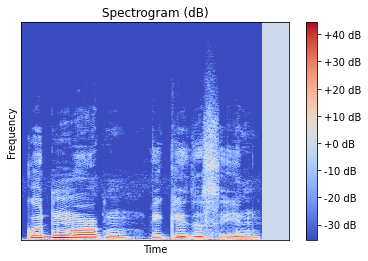

In [19]:
# 4. 데이터 확인하기
for (X_train,Y_train) in train_loader:
    print("X_train : ",X_train.size(),'type:',X_train.type())
    print("Y_train : ",Y_train.size(),'type:',Y_train.type())
    break
    
print(Y_train[0])
librosa.display.specshow(X_train[0][0].numpy(), sr=sr, hop_length=hop_length)
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar(format='%+2.0f dB')
plt.title("Spectrogram (dB)")
#batch: 32 / 3채널 / frame수: 500  /  feature수: 13

X_valid :  torch.Size([16, 3, 626, 300]) type: torch.FloatTensor
Y_valid :  torch.Size([16]) type: torch.LongTensor
tensor(1)


Text(0.5, 1.0, 'Spectrogram (dB)')

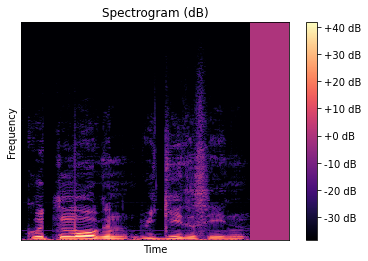

In [20]:
#valiation set 확인
for (X_valid,Y_valid) in validation_loader:
    print("X_valid : ",X_valid.size(),'type:',X_valid.type())
    print("Y_valid : ",Y_valid.size(),'type:',Y_valid.type())
    break

print(Y_valid[0])
librosa.display.specshow(X_valid[0][0].numpy(), sr=sr, hop_length=hop_length)
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar(format='%+2.0f dB')
plt.title("Spectrogram (dB)")

#batch: 32 / 3채널 / frame수: 500  /  feature수: 13

X_valid :  torch.Size([16, 3, 626, 300]) type: torch.FloatTensor
Y_valid :  torch.Size([16]) type: torch.LongTensor
tensor(1)


Text(0.5, 1.0, 'Spectrogram (dB)')

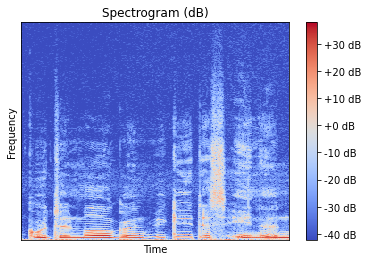

In [21]:
#valiation set 확인
for (test_data,test_label) in validation_loader:
    print("X_valid : ",test_data.size(),'type:',test_data.type())
    print("Y_valid : ",test_label.size(),'type:',test_label.type())
    break

print(Y_valid[0])
librosa.display.specshow(test_data[0][0].numpy(), sr=sr, hop_length=hop_length)
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar(format='%+2.0f dB')
plt.title("Spectrogram (dB)")

#batch: 32 / 3채널 / frame수: 500  /  feature수: 13

# RESNET

In [13]:
# 모델 
# pretrained


def model_initialize():
    model = models.resnet34(pretrained=True).cuda()
    model.ftrs = model.fc.in_features # in_features : fully connected의 입력수.
    num_ftrs = model.fc.in_features

    model.fc = nn.Sequential(nn.Linear(num_ftrs, 256),
                             nn.BatchNorm1d(256),
                             nn.ReLU(),
                             nn.Dropout(p=0.5),
                             nn.Linear(256,128),
                             nn.BatchNorm1d(128),
                             nn.ReLU(),
                             nn.Dropout(p=0.5),
                             nn.Linear(128,64),
                             nn.BatchNorm1d(64),
                             nn.ReLU(),
                             nn.Dropout(p=0.5),
                             nn.Linear(64,50),
                             nn.BatchNorm1d(50),
                             nn.ReLU(),
                             nn.Dropout(p=0.5),
                             nn.Linear(50,2)
                            )

    model = model.cuda()
    return model
model=model_initialize()


In [14]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.0001)
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [24]:
# get the model summary
from torchsummary import summary
summary(model, input_size=(3, 128, 300), device=DEVICE.type)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 64, 64, 150]           9,408
       BatchNorm2d-2          [-1, 64, 64, 150]             128
              ReLU-3          [-1, 64, 64, 150]               0
         MaxPool2d-4           [-1, 64, 32, 75]               0
            Conv2d-5           [-1, 64, 32, 75]          36,864
       BatchNorm2d-6           [-1, 64, 32, 75]             128
              ReLU-7           [-1, 64, 32, 75]               0
            Conv2d-8           [-1, 64, 32, 75]          36,864
       BatchNorm2d-9           [-1, 64, 32, 75]             128
             ReLU-10           [-1, 64, 32, 75]               0
       BasicBlock-11           [-1, 64, 32, 75]               0
           Conv2d-12           [-1, 64, 32, 75]          36,864
      BatchNorm2d-13           [-1, 64, 32, 75]             128
             ReLU-14           [-1, 64,

In [15]:
#8. 학습
def train(model,train_loader,optimizer, log_interval):
    model.train()
    correct = 0
    train_loss = 0
    for batch_idx,(image,label) in enumerate(train_loader):
        image = image.to(DEVICE)
        label = label.to(DEVICE)
        #데이터들 장비에 할당
        optimizer.zero_grad() # device 에 저장된 gradient 제거
        output = model(image) # model로 output을 계산
        loss = criterion(output, label) #loss 계산
        train_loss += loss.item()
        prediction = output.max(1,keepdim=True)[1] # 가장 확률이 높은 class 1개를 가져온다.그리고 인덱스만
        correct += prediction.eq(label.view_as(prediction)).sum().item()# 아웃풋이 배치 사이즈 32개라서.
        loss.backward() # loss 값을 이용해 gradient를 계산
        optimizer.step() # Gradient 값을 이용해 파라미터 업데이트.
    train_loss/=len(train_loader.dataset)
    train_accuracy = 100. * correct / len(train_loader.dataset)
    return train_loss,train_accuracy


In [16]:
#9. 학습 진행하며, validation 데이터로 모델 성능확인
def evaluate(model,valid_loader):
    model.eval()
    valid_loss = 0
    correct = 0
    #no_grad : 그래디언트 값 계산 막기.
    with torch.no_grad():
        for image, label in valid_loader:
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image)
            valid_loss += criterion(output, label).item()
            prediction = output.max(1,keepdim=True)[1] # 가장 확률이 높은 class 1개를 가져온다.그리고 인덱스만
            correct += prediction.eq(label.view_as(prediction)).sum().item()# 아웃풋이 배치 사이즈 32개라서.
            #true.false값을 sum해줌. item
        valid_loss /= len(valid_loader.dataset)
        valid_accuracy = 100. * correct / len(valid_loader.dataset)
        return valid_loss,valid_accuracy


In [17]:
#데이터 로더 제작 함수

def load_data(data_ind):

    train_loader = torch.utils.data.DataLoader(dataset = 
                                               svd_dataset(
                                                   X_train_list,
                                                   classes,
                                                   transform = transforms.ToTensor(),#이걸 composed로 고쳐서 전처리 하도록 수정.
                                                   data_num=data_ind,
                                                   training=True
                                               ),
                                               batch_size = BATCH_SIZE,
                                               shuffle = True,
                                               ) # 순서가 암기되는것을 막기위해.

    validation_loader = torch.utils.data.DataLoader(dataset = 
                                               svd_dataset(
                                                   X_valid_list,
                                                   classes,
                                                   transform = transforms.ToTensor(),
                                                   data_num=data_ind,
                                                   training=False
                                               ),
                                               batch_size = BATCH_SIZE,
                                               shuffle = True,) 
    return train_loader,validation_loader



In [28]:
#10. 학습 및 평가.
# resnet34 pretrained true
# kfold 적용

train_accs = []
valid_accs = []

for data_ind in range(1,6):

    check_path = '../../checkpoint/checkpoint_spectro_resnet18_true_ros_'+str(data_ind)+'_300.pt'
    print(check_path)
    early_stopping = EarlyStopping(patience = 5, verbose = True, path=check_path)
    train_loader,validation_loader = load_data(data_ind-1)
    
    best_train_acc=0 # accuracy 기록용
    best_valid_acc=0
    
    model=model_initialize()
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(),lr=0.0001)
    
    
    print("[{} 교차검증] 학습 시작\n ----- ".format(data_ind))
    for Epoch in range(1,EPOCHS+1):
        train_loss,train_accuracy=train(model,train_loader,optimizer,log_interval=31)
        valid_loss,valid_accuracy = evaluate(model, validation_loader)


        print("\n[EPOCH:{}]\t Train Loss:{:.4f}\t Train Acc:{:.2f} %  | \tValid Loss:{:.4f} \tValid Acc: {:.2f} %\n".
              format(Epoch,train_loss,train_accuracy,valid_loss,valid_accuracy))
        

        early_stopping(valid_loss, model)
        if -early_stopping.best_score == valid_loss:
            best_train_acc, best_valid_acc = train_accuracy,valid_accuracy
        
        if early_stopping.early_stop:
                train_accs.append(best_train_acc)
                valid_accs.append(best_valid_acc)
                print("[{} 교차검증] Early stopping".format(data_ind))
                break

        if Epoch==EPOCHS:
            #만약 early stop 없이 40 epoch라서 중지 된 경우.
            train_accs.append(best_train_acc)
            valid_accs.append(best_valid_acc)

../../checkpoint/checkpoint_spectro_resnet18_true_ros_1_300.pt
[1 교차검증] 학습 시작
 ----- 

[EPOCH:1]	 Train Loss:0.0449	 Train Acc:55.24 %  | 	Valid Loss:0.0385 	Valid Acc: 66.49 %

Validation loss decreased (inf --> 0.038478).  Saving model ...

[EPOCH:2]	 Train Loss:0.0417	 Train Acc:59.55 %  | 	Valid Loss:0.0346 	Valid Acc: 78.27 %

Validation loss decreased (0.038478 --> 0.034627).  Saving model ...

[EPOCH:3]	 Train Loss:0.0391	 Train Acc:64.73 %  | 	Valid Loss:0.0329 	Valid Acc: 82.72 %

Validation loss decreased (0.034627 --> 0.032892).  Saving model ...

[EPOCH:4]	 Train Loss:0.0351	 Train Acc:71.14 %  | 	Valid Loss:0.0302 	Valid Acc: 82.20 %

Validation loss decreased (0.032892 --> 0.030157).  Saving model ...

[EPOCH:5]	 Train Loss:0.0330	 Train Acc:75.00 %  | 	Valid Loss:0.0309 	Valid Acc: 86.39 %

EarlyStopping counter: 1 out of 5

[EPOCH:6]	 Train Loss:0.0294	 Train Acc:78.99 %  | 	Valid Loss:0.0253 	Valid Acc: 88.48 %

Validation loss decreased (0.030157 --> 0.025262).  Savin


[EPOCH:13]	 Train Loss:0.0126	 Train Acc:95.22 %  | 	Valid Loss:0.0202 	Valid Acc: 86.65 %

EarlyStopping counter: 1 out of 5

[EPOCH:14]	 Train Loss:0.0096	 Train Acc:96.66 %  | 	Valid Loss:0.0238 	Valid Acc: 83.77 %

EarlyStopping counter: 2 out of 5

[EPOCH:15]	 Train Loss:0.0082	 Train Acc:97.71 %  | 	Valid Loss:0.0189 	Valid Acc: 88.48 %

Validation loss decreased (0.020017 --> 0.018929).  Saving model ...

[EPOCH:16]	 Train Loss:0.0079	 Train Acc:97.64 %  | 	Valid Loss:0.0187 	Valid Acc: 88.22 %

Validation loss decreased (0.018929 --> 0.018734).  Saving model ...

[EPOCH:17]	 Train Loss:0.0090	 Train Acc:96.60 %  | 	Valid Loss:0.0197 	Valid Acc: 87.96 %

EarlyStopping counter: 1 out of 5

[EPOCH:18]	 Train Loss:0.0101	 Train Acc:95.68 %  | 	Valid Loss:0.0336 	Valid Acc: 79.84 %

EarlyStopping counter: 2 out of 5

[EPOCH:19]	 Train Loss:0.0084	 Train Acc:96.60 %  | 	Valid Loss:0.0193 	Valid Acc: 87.96 %

EarlyStopping counter: 3 out of 5

[EPOCH:20]	 Train Loss:0.0063	 Train Acc

# Model 결과 확인

In [29]:
sum_valid=0
for data_ind in range(5):
    print("[{} 교차검증] train ACC : {:.4f} |\t valid ACC: {:.4f} ".format(data_ind+1,train_accs[data_ind],valid_accs[data_ind] ))
    sum_valid+=valid_accs[data_ind]
    
print("평균 검증 정확도",sum_valid/5,"%")

[1 교차검증] train ACC : 96.4660 |	 valid ACC: 93.7173 
[2 교차검증] train ACC : 96.3351 |	 valid ACC: 91.0995 
[3 교차검증] train ACC : 97.6440 |	 valid ACC: 88.2199 
[4 교차검증] train ACC : 96.1387 |	 valid ACC: 87.1728 
[5 교차검증] train ACC : 95.8115 |	 valid ACC: 90.5759 
평균 검증 정확도 90.15706806282722 %


# Model Test

- test set
- confusion matrix

In [18]:
#confusion matrix 계산
#test set 계산.
def test_evaluate(model,test_loader):
    model.eval()
    test_loss = 0
    predictions = []
    answers = []
    #no_grad : 그래디언트 값 계산 막기.
    with torch.no_grad():
        for image, label in test_loader:
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image)
            test_loss += criterion(output, label).item()
            prediction = output.max(1,keepdim=True)[1] # 가장 확률이 높은 class 1개를 가져온다.그리고 인덱스만
            answers +=label
            predictions +=prediction
            
        return predictions,answers,test_loss
            

In [19]:
# Confusion matrix (resnet18)
# kfold의 confusion matrix는 계산 방법이 다르다.
# 모델을 각각 불러와서 test set을 평가한다.

from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

cf = np.zeros((2,2))
cf_list = []
average_accuracy = 0
average_fscore = 0

for data_ind in range(1,6):

    check_path = '../../checkpoint/checkpoint_spectro_resnet18_true_ros_'+str(data_ind)+'_300.pt'
    model.load_state_dict(torch.load(check_path))

    predictions,answers,test_loss = test_evaluate(model, test_loader)
    predictions=[ dat.cpu().numpy() for dat in predictions]
    answers=[ dat.cpu().numpy() for dat in answers]

    
    cf = confusion_matrix(answers, predictions)
    cf_list.append(cf)
    
    acc = (cf[0,0]+cf[1,1])/(cf[0,0]+cf[0,1]+cf[1,0]+cf[1,1])
    average_accuracy+=acc
    precision=cf[0,0]/(cf[0,0]+cf[1,0])
    recall=cf[0,0]/(cf[0,0]+cf[0,1])
    #fscore=2*precision*recall/(precision+recall)
    
    #fscroe macro추가
    fscore = f1_score(answers,predictions,average='macro')
    average_fscore+=fscore
    
    print('{}번 모델'.format(data_ind))
    print("Accuracy : {:.4f}% ".format(acc*100))
    print("Precision (pathology 예측한 것중 맞는 것) : {:.4f}".format(precision))
    print("recall (실제 pathology 중  예측이 맞는 것) : {:.4f}".format(recall))
    print("f score : {:.4f} ".format(fscore))
    print(cf)
    print("-----")

print("평균 acc : {:.4f}".format(average_accuracy/5))
print("평균 f1score : {:.4f}".format(average_fscore/5))




1번 모델
Accuracy : 85.2459% 
Precision (pathology 예측한 것중 맞는 것) : 0.8807
recall (실제 pathology 중  예측이 맞는 것) : 0.8954
f score : 0.8360 
[[214  25]
 [ 29  98]]
-----
2번 모델
Accuracy : 81.4208% 
Precision (pathology 예측한 것중 맞는 것) : 0.8178
recall (실제 pathology 중  예측이 맞는 것) : 0.9205
f score : 0.7813 
[[220  19]
 [ 49  78]]
-----
3번 모델
Accuracy : 81.1475% 
Precision (pathology 예측한 것중 맞는 것) : 0.8829
recall (실제 pathology 중  예측이 맞는 것) : 0.8201
f score : 0.7979 
[[196  43]
 [ 26 101]]
-----
4번 모델
Accuracy : 83.3333% 
Precision (pathology 예측한 것중 맞는 것) : 0.8803
recall (실제 pathology 중  예측이 맞는 것) : 0.8619
f score : 0.8178 
[[206  33]
 [ 28  99]]
-----
5번 모델
Accuracy : 79.7814% 
Precision (pathology 예측한 것중 맞는 것) : 0.8090
recall (실제 pathology 중  예측이 맞는 것) : 0.9038
f score : 0.7632 
[[216  23]
 [ 51  76]]
-----
평균 acc : 0.8219
평균 f1score : 0.7992


# 기타

In [32]:
#크기 알아보기
#일반 CNN

m = nn.MaxPool2d(2, stride=2)
#m = nn.MaxPool2d((3, 2), stride=(2, 1))
input = torch.randn(32, 1, 500, 13)
print(input.size())
output = m(input)
print(output.size())
output = m(output)
print(output.size())

torch.Size([32, 1, 500, 13])
torch.Size([32, 1, 250, 6])
torch.Size([32, 1, 125, 3])


In [33]:
#크기 알아보기
#주파수 영역 CNN

input = torch.randn(32, 1, 500, 13)
m=nn.Conv2d(
            in_channels = 1,# 채널이 1개
            out_channels = 32,# FeatureMap 수,커널 수
            kernel_size = (1,13),#1x13  no padding
        )
output=m(input)
print(output.size())
m=nn.Conv2d(
            in_channels = 32,# 채널이 1개
            out_channels = 64,# FeatureMap 수,커널 수
            kernel_size = (27,1),#9 x 1 no padding
        )
output=m(output)
print(output.size())


torch.Size([32, 32, 500, 1])
torch.Size([32, 64, 474, 1])


In [34]:
input = torch.randn(500, 13)

out=torch.stack([input,input,input])
out.size()

torch.Size([3, 500, 13])